In [1]:
!which python

/Users/esp.py/Projects/Personal/end-to-end-rag/.venv/bin/python


### News Summarizer

In this post I will try to implement a news summarizer. 

Over the past month I have been collecting a lot of news article from major congolese website news webisite. I have those article saved in a postgres database. There are lot of fun stuff I can do with them. Among them there is a news summarizer. I want to analyze the daily news and find out what are the main news the website are talking about.

In this blog or series of post I will try to build that news summarizer. As of now I will structure it as follow. 
- Kmean clustering
- Text Summarization with a Language Model
- Deployment to Production and Building the UI

### Data Collection

We have the data save as text in a postgres database in this section we will query the database and load the data in a pandas dataframe for better analyzis. I have the code to connect and read from the postgres database embedded in modules

In [2]:
%load_ext dotenv

In [3]:
%dotenv ./.env_prod -o

The above line loads the database credentatials so that we can query the database.

In [4]:
from src.rag.shared.database import execute_query, generate_database_connection

In [5]:
yesterday_article_query = "select content, title, posted_at,url from article where posted_at::date = CURRENT_DATE - interval '1 day'"

In [6]:
from os import getenv

In [7]:
database_user = getenv('POSTGRES_USER')
database_password = getenv('POSTGRES_PASSWORD')
database_host = getenv('POSTGRES_HOST')
database_port = getenv('POSTGRES_PORT')
database_name = getenv('POSTGRES_DB')

In [8]:
database_credentials = {
    'user': database_user,
    'password': database_password,
    'host': database_host,
    'port': database_port,
    'database': database_name
}

In [9]:
connection = generate_database_connection(database_crendentials=database_credentials)

With the credentials, the database connection, the query we can go ahead and query the database to retrieve the data.

In [10]:
results =execute_query(query=yesterday_article_query, database_connection=connection)

In [11]:
results[0].title

'Confiscation du passeport de la veuve Michèle Samba Malata\xa0: La DGM tue Chérubin Okende\xa0pour la deuxième fois'

We have our results in a list now we can put them in a dataframe from further analysis.

In [12]:
import pandas as pd

In [13]:
news_df  = pd.DataFrame.from_records(results)

In [14]:
news_df.head()

,0,1,2,3
0,"Curieusement, jusqu’à ce jour, son document d’...",Confiscation du passeport de la veuve Michèle ...,2024-10-17 08:50:55,https://scooprdc.net/2024/10/17/confiscation-d...
1,"Tenez, en date du 11 septembre 2024, il dépose...","Secteur minier : Par faux et usage de faux, Vi...",2024-10-17 13:44:13,https://scooprdc.net/2024/10/17/secteur-minier...
2,En marge de la commémoration de la journée mon...,Journée mondiale de la normalisation : L’OCC p...,2024-10-17 07:45:56,https://scooprdc.net/2024/10/17/journee-mondia...
3,Juste après sa participation à la 75 session ...,"7,3millions des déplacés dans l’Est de la RDC ...",2024-10-17 08:24:52,https://scooprdc.net/2024/10/17/73millions-des...
4,Alors que le débat sur une éventuelle révision...,Révision de la Constitution en RDC : Le Forum ...,2024-10-17 07:05:00,https://actualite.cd/index.php/2024/10/17/revi...


In [15]:
news_df.columns =  ["content", "title", "posted_at", "url"]

In [16]:
from pathlib import Path

In [17]:
current_directory = Path.cwd().parent.parent

In [18]:
news_directory = current_directory.joinpath("datasets", "today_news")

In [19]:
news_directory.mkdir(exist_ok=True)

In [20]:
from datetime import datetime

In [21]:
today = datetime.now().strftime("%Y-%m-%d")

In [22]:
news_df.to_csv(news_directory.joinpath(f"{today}-news.csv"))

In [23]:
news_df.head()

,content,title,posted_at,url
0,"Curieusement, jusqu’à ce jour, son document d’...",Confiscation du passeport de la veuve Michèle ...,2024-10-17 08:50:55,https://scooprdc.net/2024/10/17/confiscation-d...
1,"Tenez, en date du 11 septembre 2024, il dépose...","Secteur minier : Par faux et usage de faux, Vi...",2024-10-17 13:44:13,https://scooprdc.net/2024/10/17/secteur-minier...
2,En marge de la commémoration de la journée mon...,Journée mondiale de la normalisation : L’OCC p...,2024-10-17 07:45:56,https://scooprdc.net/2024/10/17/journee-mondia...
3,Juste après sa participation à la 75 session ...,"7,3millions des déplacés dans l’Est de la RDC ...",2024-10-17 08:24:52,https://scooprdc.net/2024/10/17/73millions-des...
4,Alors que le débat sur une éventuelle révision...,Révision de la Constitution en RDC : Le Forum ...,2024-10-17 07:05:00,https://actualite.cd/index.php/2024/10/17/revi...


We have got our news dataset, we need to now do some preprocessing. The only preprocessing we will do will be to drop the duplicate in the content.

In [24]:
news_df = news_df.drop_duplicates(subset="content").reset_index(drop=True)

In [25]:
news_df

,content,title,posted_at,url
0,"Curieusement, jusqu’à ce jour, son document d’...",Confiscation du passeport de la veuve Michèle ...,2024-10-17 08:50:55,https://scooprdc.net/2024/10/17/confiscation-d...
1,"Tenez, en date du 11 septembre 2024, il dépose...","Secteur minier : Par faux et usage de faux, Vi...",2024-10-17 13:44:13,https://scooprdc.net/2024/10/17/secteur-minier...
2,En marge de la commémoration de la journée mon...,Journée mondiale de la normalisation : L’OCC p...,2024-10-17 07:45:56,https://scooprdc.net/2024/10/17/journee-mondia...
3,Juste après sa participation à la 75 session ...,"7,3millions des déplacés dans l’Est de la RDC ...",2024-10-17 08:24:52,https://scooprdc.net/2024/10/17/73millions-des...
4,Alors que le débat sur une éventuelle révision...,Révision de la Constitution en RDC : Le Forum ...,2024-10-17 07:05:00,https://actualite.cd/index.php/2024/10/17/revi...
...,...,...,...,...
68,Prenant la parole pour faire l’économie de ce ...,Assemblée nationale : Doudou Fwamba rassure le...,2024-10-17 10:32:24,https://actu30.cd/2024/10/assemblee-nationale-...
69,"Au cœur des échanges, la problématique d’appro...",RDC – Approvisionnement en carburants : le Gro...,2024-10-17 13:11:00,https://actu30.cd/2024/10/rdc-approvisionnemen...
70,Ces engins constitués de plusieurs camions et ...,Kasaï – Central : Sesanga dote la population d...,2024-10-17 10:22:25,https://actu30.cd/2024/10/kasai-central-sesang...
71,Cette activité a lancé officiellement la campa...,Kinshasa : L’ONG Wife sensibilise les femmes à...,2024-10-17 07:11:58,https://actu30.cd/2024/10/kinshasa-long-wife-s...


Once we have dataset, we will need to use an embedding  model to learn representation of our dataset in an embedding space.

We will be using the `dunzhang/stella_en_400M_v5`, it is a good model from huggingface despite his size it has a good score on different tasks  in both French and English on the MTEB leaderboard.

In [26]:
embedding_model_id = "dunzhang/stella_en_400M_v5"

In [27]:
current_directory

PosixPath('/Users/esp.py/Projects/Personal/end-to-end-rag')

In [28]:
model_path  = current_directory.joinpath(embedding_model_id)

In [29]:
embedding_model_path = current_directory.joinpath("models", embedding_model_id)

In [30]:

transformer_kwargs = {"model_name_or_path": embedding_model_path.__str__(),
                      "trust_remote_code": True,
                      "device": "cpu",
                      "config_kwargs": {"use_memory_efficient_attention": False,
                                        "unpad_inputs": False},
                      "cache_folder": model_path}

In [31]:
from sentence_transformers import SentenceTransformer

/Users/esp.py/Projects/Personal/end-to-end-rag/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [32]:
sentence_transformer_model = SentenceTransformer(
    **transformer_kwargs)

Some weights of the model checkpoint at /Users/esp.py/Projects/Personal/end-to-end-rag/models/dunzhang/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
today_news_embeddings = sentence_transformer_model.encode(
    news_df.content.tolist())

/Users/esp.py/Projects/Personal/end-to-end-rag/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py:1141: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [34]:
today_news_embeddings.shape

(73, 1024)

Now we have encoded our news in the embeddings, for each news we have an embedding vector of shape 1024. With those embedding we can now start clustering our news.



## Kmeans

In this step, we will group our news embeddings in a cluster using the Kmean algorithm. The algorithm will try to group the news in clusters based on the similarity of their embedding vectors. After the clustering, we will have similar news grouped in similar clusters.

### How do we pick the number of cluster?

We will use the Shilouette score to get the best number of clusters.

>The Silhouette Coefficient is a measure of how well samples are clustered with samples that are similar to themselves. Clustering models with a high Silhouette Coefficient are said to be dense, where samples in the same cluster are similar to each other, and well separated, where samples in different clusters are not very similar to each other.



Given the a point $x_i$, and a cluster label $c_i$ to compute the shilloute score:
- we compute the mean distance of the $x_i$ to all the point in cluster $c_i$, we call it $a_i$

  ${\displaystyle a_i={\frac {1}{|C_{I}|-1}}\sum _{j\in C_{I},i\neq j}d(i,j)}$

  Note that we divide by don't want to include the current point when we are trying to compute the distance.
  
- $b_i$ is the a measure to how the point $x_i$ in cluster $c_i$ is disimilar to all other clusters $c_j$ with $c_j != c_i$.

For each other clusters different $c_i$ we compute the mean distance between $x_i$ and all the points in the cluster.  Then we take the cluster that has the mean distance as the closest cluster to $x_i$.

We define $b_i$ as:

${\displaystyle b_i=\min _{J\neq I}{\frac {1}{|C_{J}|}}\sum _{j\in C_{J}}d(i,j)}$


With those $a_i$, and $b_I$ we define the shiloute score of the point $x_i$ as $s_i$ to be

${\displaystyle s_i={\frac {b_i-a_i}{\max\{a_i,b_i\}}}}$

This value varies between -1, and 1. 1 means our clusters are dense, and -1 means the opposite.

Let us write a python function that will perform the clustering and return the k that gives us the best cluster.


In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [36]:

def find_best_estimator (X):
    """ compute the k mean clustering, and return the best k that maximize the silhouette score
    """
    k_mean_estimators = [
        (f"KMeans_{i}", KMeans(n_clusters=i, random_state=42, max_iter=3000)) for i in range(3, X.shape[0])]
    scores = []

    best_estimator = None
    best_metric = float("-inf")
    for estimator_name, estimator in k_mean_estimators :
        estimator.fit(X)
        labels = estimator.labels_
        score = silhouette_score(
            X, labels)
        if score > best_metric :
            best_metric = score
            best_estimator = estimator
        print(estimator_name, score)
        scores.append(score)
    return best_estimator, scores

In [37]:
best_estimator, scores = find_best_estimator(today_news_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


KMeans_3 0.024779674
KMeans_4 0.05520056
KMeans_5 0.045455392
KMeans_6 0.04964463
KMeans_7 0.056659978
KMeans_8 0.05081347
KMeans_9 0.056122217
KMeans_10 0.06609015
KMeans_11 0.067076065
KMeans_12 0.06721259
KMeans_13 0.07011214
KMeans_14 0.07304835
KMeans_15 0.07871313
KMeans_16 0.07618594
KMeans_17 0.07951676
KMeans_18 0.073466286
KMeans_19 0.08596306
KMeans_20 0.08924498
KMeans_21 0.0939352
KMeans_22 0.098436944
KMeans_23 0.09665926
KMeans_24 0.09860402
KMeans_25 0.09625143
KMeans_26 0.09712995
KMeans_27 0.098713264
KMeans_28 0.10064369
KMeans_29 0.09718924
KMeans_30 0.10375373
KMeans_31 0.108036704
KMeans_32 0.108666494
KMeans_33 0.103939615
KMeans_34 0.104991764
KMeans_35 0.10640185
KMeans_36 0.10373604
KMeans_37 0.10306646
KMeans_38 0.09971704
KMeans_39 0.09797076
KMeans_40 0.09420552
KMeans_41 0.096739165
KMeans_42 0.09529492
KMeans_43 0.0955067
KMeans_44 0.096502885
KMeans_45 0.10128164
KMeans_46 0.10306235
KMeans_47 0.10580888
KMeans_48 0.10573358
KMeans_49 0.10409078
KMeans_5

In the above function we compute the shiloutte score for values for k ranging from 2 to the max number of datapoints in our dataset.


Let plot now the similarity shilouette score and see how it grow with the number of cluster selected.

In [38]:
import matplotlib.pyplot as plt

In [39]:
axes = plt.figure(figsize=(5, 10))

<Figure size 500x1000 with 0 Axes>

In [40]:
axes = plt.figure(figsize=(5, 10))

<Figure size 500x1000 with 0 Axes>

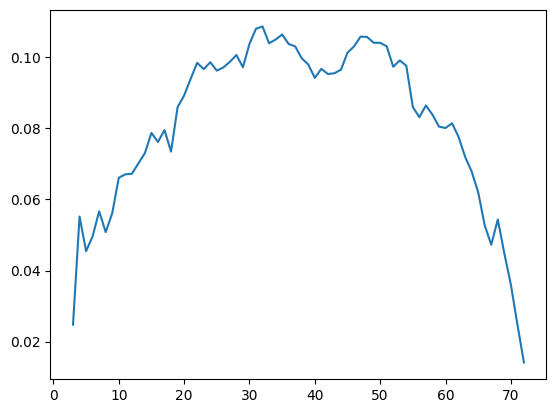

In [41]:
fig, ax = plt.subplots()
ax.plot(range(3, today_news_embeddings.shape[0]), scores)

In [42]:
best_estimator

KMeans(max_iter=3000, n_clusters=32, random_state=42)

We can see that the best estimator gave us the n cluster equal to 29

In [43]:
news_df["k_means_labels"] = best_estimator.labels_

Now let us analyze the clustering results.

In [44]:
def analyse_embeddings(dataframe, embeddings, index, label_column="labels"):
    """ take a matrix of embeddings and the labels.
    for each label compute the cosine similarity of the document with that label.
    """
    document_in_index = dataframe.query(f"{label_column} == {index}")
    with pd.option_context('display.max_colwidth', None):
        display(document_in_index.title)
    document_index = document_in_index.index
    vectors = embeddings[document_index]
    return sentence_transformer_model.similarity(vectors,  vectors)

In [45]:
analyse_embeddings(news_df, today_news_embeddings,29, label_column="k_means_labels")

17                                                                                          Belgique : Judith Suminwa séjourne à Bruxelles pour le forum Rebranding Africa
54    Participation de la RDC au 10ème Forum Rebranding Africa : la Première ministre Judith Suminwa en mission à Bruxelles pour représenter le Président Félix Tshisekedi
Name: title, dtype: object

tensor([[1.0000, 0.9254],
        [0.9254, 1.0000]])

After the first look at the results we can see that the results are good, we have around 29 news cluster, for 72 news.
Some news cluster have only one article which make sense, and othe have up to 6 articles. In the later analyzis we will only keep news articles that have more than one documents.

Can we do better than that? Let now try hiearchical clustering

## Hiearchical Clustering

Hierarchical clustering is a clustering that uses an iterative approach to build the dendrogram.


**How do we build a dendrogram?**

Assuming we have `n` points that we would like to cluster, the algorithm starts with them and a similarity metric to use.
In the first step, all the `n` points are grouped in a `n ` cluster, as each observation is treated as its cluster.
Then, the next two similar clusters are fused into a cluster; at this point, we have `n-1` clusters.
The algorithm will process iteratively  by fusing each cluster into each other until we have one cluster.  
With one cluster we have our dendrogram complete.

** How do we compute similarity between clusters?**

We have the notion between similarity between two points, how do we compute the similartiy between a point and a cluster? or Between two clusters?
The notion of similarity between two points can be extend to develop the notion of `linkage` which is how we evaluate the dissimiarity between two groups of observation or clusters.


The linkage between two cluster is :

Put the definition



In [46]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

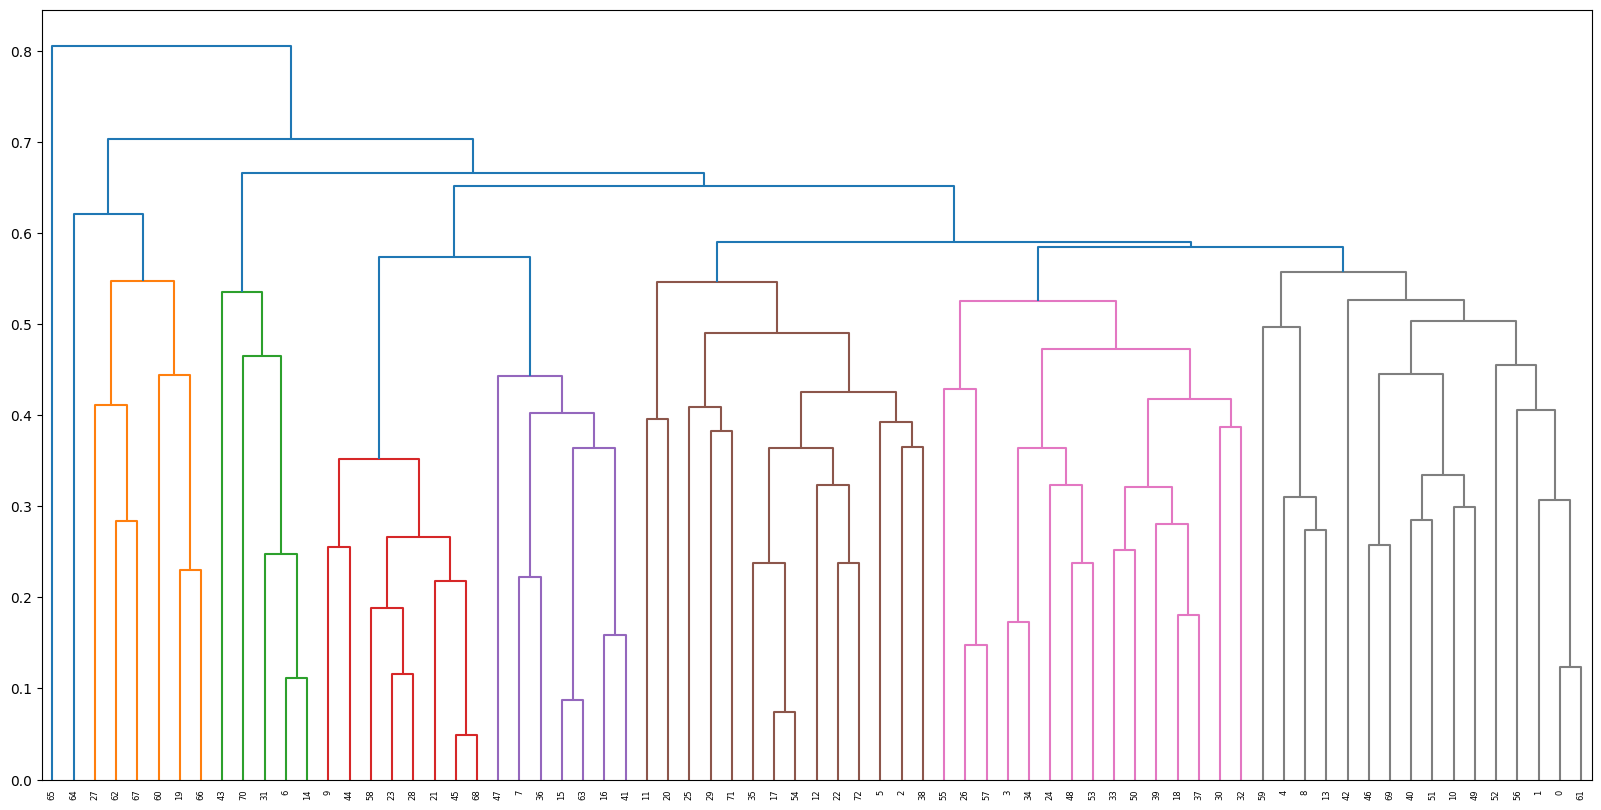

In [47]:
# Complete Linkage
plt.figure(figsize = (20,10))
mergings = linkage(today_news_embeddings,
                   method='complete', metric='cosine')
dendrogram(mergings)
plt.show()

The linkage method from scipy will make a hierachical clustering using the cosine similarity as the metrics for our embedding.
On the above plot, the x axis represent the document which are group into cluster based on th colour, the y axis represent the distance cutt off use while computing the merging.

In [48]:
from scipy.cluster.hierarchy import fcluster
import numpy as np

from the linkage matrix we can return the label using a metric cutt off.

How do we select the best metric cut-offm to use for the clustering?
We will use the Shilouette score and the do the same approach we used with the kmean. We will select the metric that gives us a high silhouette score

In [49]:
def select_best_distance(X, merging):
    """ start with the document embedding x, and the hierachical clustering, find the k that maximize the shilouette score"""
    max_shilouette = float("-inf")
    return_labels = np.zeros(X.shape[0])
    scores = []
    number_of_clusters = []
    best_k = 0
    for k in np.arange(0.2, 0.7, 0.01):
        labels = fcluster(merging, k, criterion="distance")
        score = silhouette_score(
            X, labels
        )
        scores.append(score)
        n_clusters = np.unique(labels).shape[0]
        number_of_clusters.append(n_clusters)
        if score > max_shilouette:
            max_shilouette = score
            return_labels = labels
            best_k = k
    return scores, return_labels, number_of_clusters, best_k

In [50]:
scores, label_hierarchical, number_of_clusters, best_k =  select_best_distance(today_news_embeddings, mergings)

Text(0.5, 1.0, 'silhouette score vs distance metric')

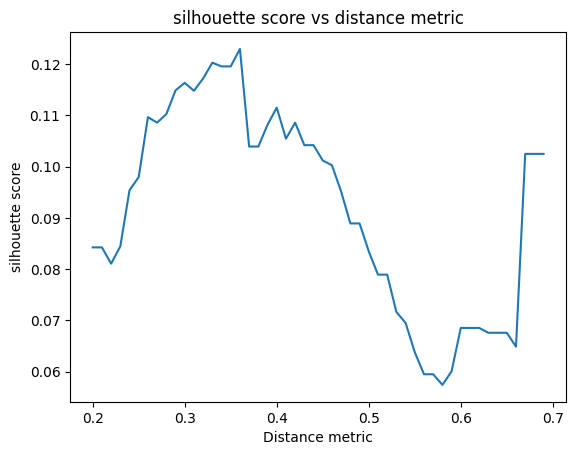

In [51]:
fig, ax = plt.subplots()
ax.plot(np.arange(0.2, 0.7, 0.01), scores)
ax.set_xlabel("Distance metric")
ax.set_ylabel("silhouette score")
ax.set_title("silhouette score vs distance metric")

In [52]:
np.unique(label_hierarchical).shape

(39,)

In [53]:
max(scores)

0.12292803

In [54]:
best_k

0.36000000000000015

Text(0.5, 1.0, 'distance vs number of clusters')

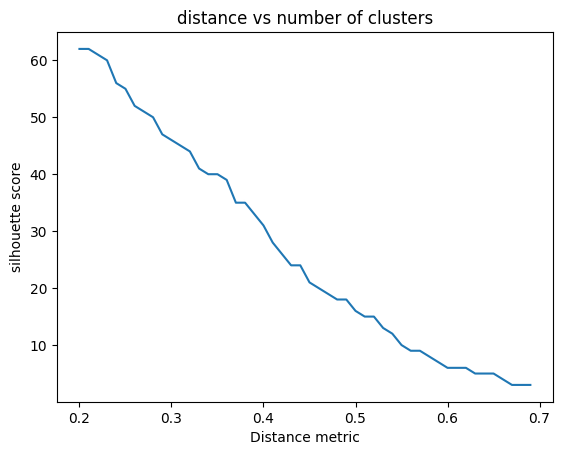

In [55]:
fig, ax = plt.subplots()
ax.plot(np.arange(0.2, 0.7, 0.01), number_of_clusters)
ax.set_xlabel("Distance metric")
ax.set_ylabel("silhouette score")
ax.set_title("distance vs number of clusters")

In [56]:
news_df["label_hierachical"] = label_hierarchical

In [57]:
news_df.query(f"label_hierachical == 0")

,content,title,posted_at,url,k_means_labels,label_hierachical


In [58]:
analyse_embeddings(news_df, today_news_embeddings, 39, "label_hierarchical")

65    Avis d'appel d'offres national - sans pré-qualification : acquisition des matériels informatiques et de communication pour le FPI | Actualite.cd
Name: title, dtype: object

tensor([[1.0000]])

Once i have got the best labeling, i can go ahead and select the most important cluster. 

This will be all the cluster with more than 1 document, the rest of the document will be considered as noise. Each cluster with one document will be considered as noise.

In [59]:
cluster_counts = news_df.label_hierachical.value_counts()
labels_with_more_than_one = cluster_counts[cluster_counts > 1].index

In [62]:
important_news_df = news_df.loc[news_df.label_hierachical.isin(labels_with_more_than_one)]

In [ ]:
important_news_df